# Importing necessary libraries

In [383]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d
from scipy.signal import tf2zpk, find_peaks

# Question 2
Compute and plot the narrowband magnitude spectrum slice using a Hamming window of duration = 30 ms on a segment near the centre of the given audio file.

In [204]:
pathToaaSound = r"D:\\EE679\\EE679\\CompAssg2\\sounds\\aa.wav" #path to the "pani" sound of machali
sampleRate, data = wavfile.read(pathToaaSound) #storing the used sample rate and the wav file in variables for analysis

In [26]:
dur = 0.03 #duration of the window in seconds
windowLength = int(sampleRate*dur) #the window length in samples (each sample is 1/sampleRate long)
totalSignalLength = int(len(data)) #the lenght of the entire signal in terms of samples
signalToAnalyse = data[totalSignalLength//2 - windowLength//2 : totalSignalLength//2 + windowLength//2] #taking the sample of the signal in the center
checkStr = "Window length matches the signal sample Proceed....." if (len(signalToAnalyse)==windowLength)  else "Check the signal sample again <Lengths do not match>"
print(checkStr) #checking whether the calculated window lenght and the lenght of windowed signal match

Window length matches the signal sample Proceed.....


## Generating the hamming window
I have used the numpy implementation of the hamming window

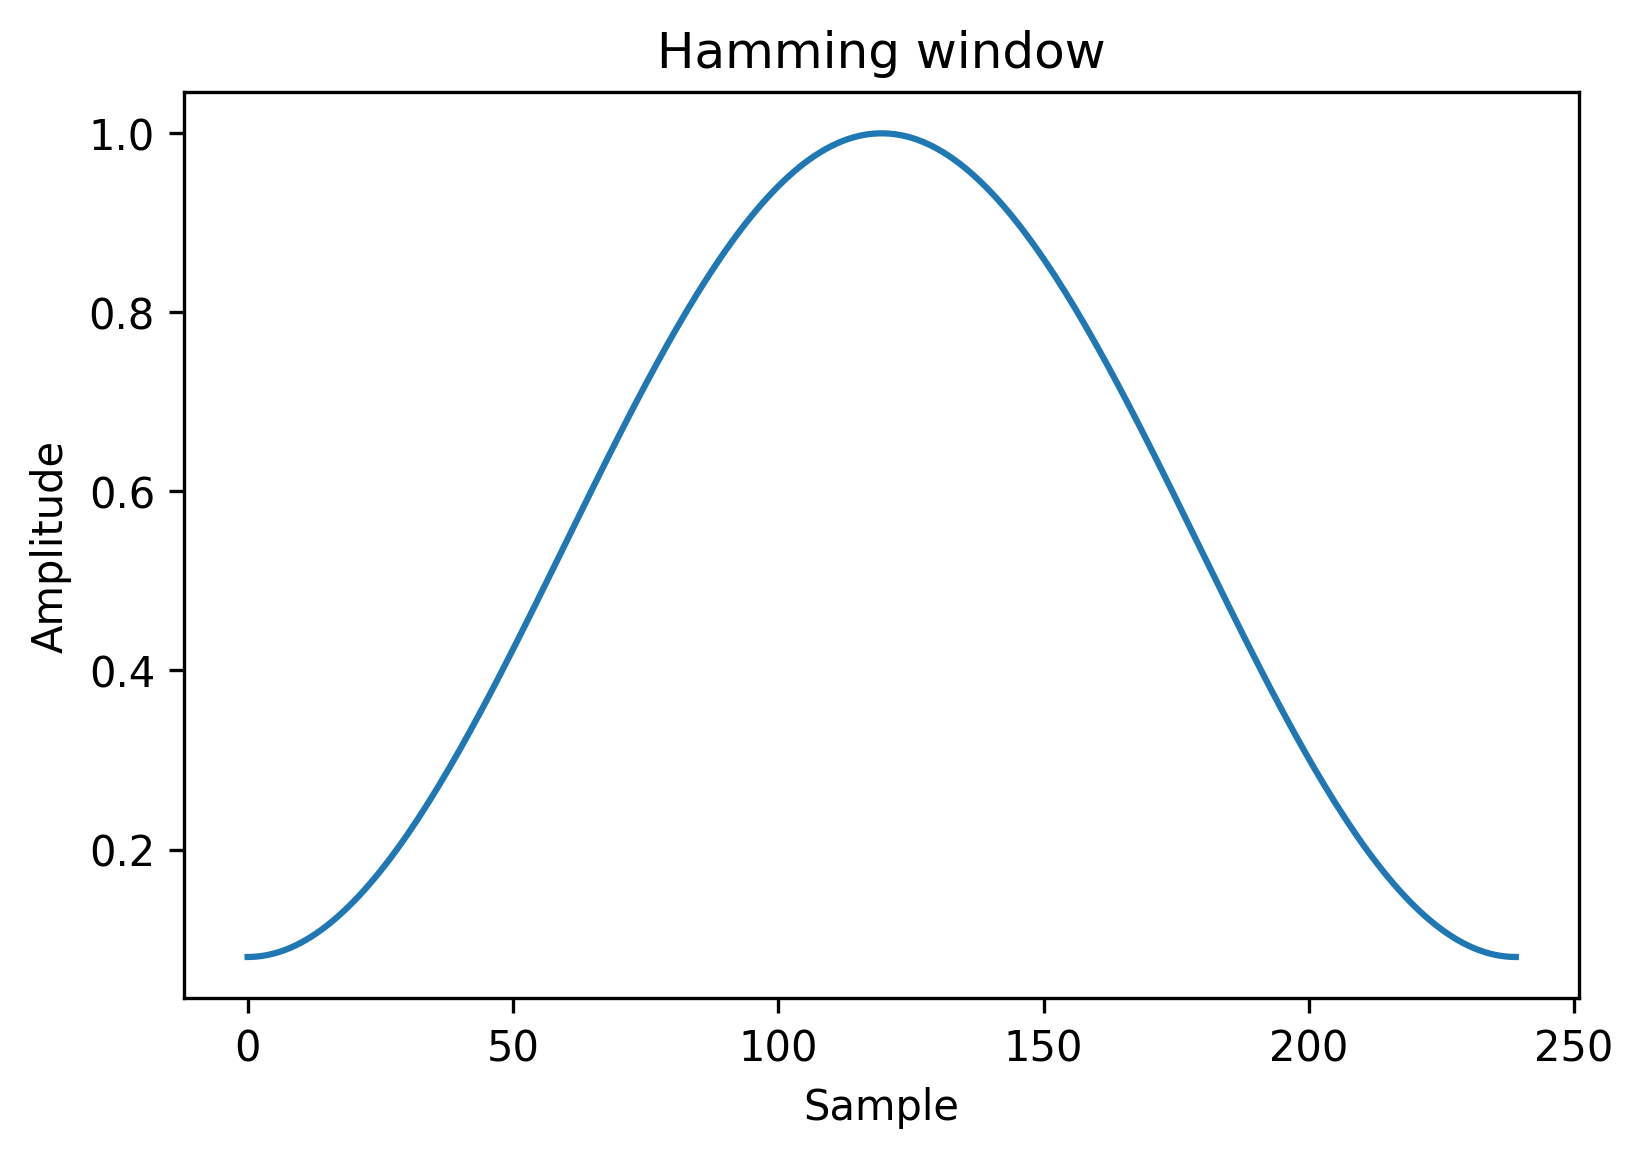

In [20]:
window = np.hamming(windowLength)
plt.gcf().set_dpi(300)
plt.plot(window) 
plt.title("Hamming window")
plt.ylabel("Amplitude") 
plt.xlabel("Sample") 
plt.show() 

## Generating the narrawband magnitude spectra
Here we multply the hamming window of appropriate length with our signal sample and take its dft. Thus, we can  generate the required magnitude plot

In [29]:
dftSize = 10000 #setting the dft size
signalAfterHamming = signalToAnalyse*np.hamming(windowLength) #choosing the hamming window
signalHammingDFT = 20*np.log(np.abs(np.fft.fft(signalAfterHamming, dftSize))[:dftSize//2]) #computing the magnitudes of the signal afterwindowing and hamming

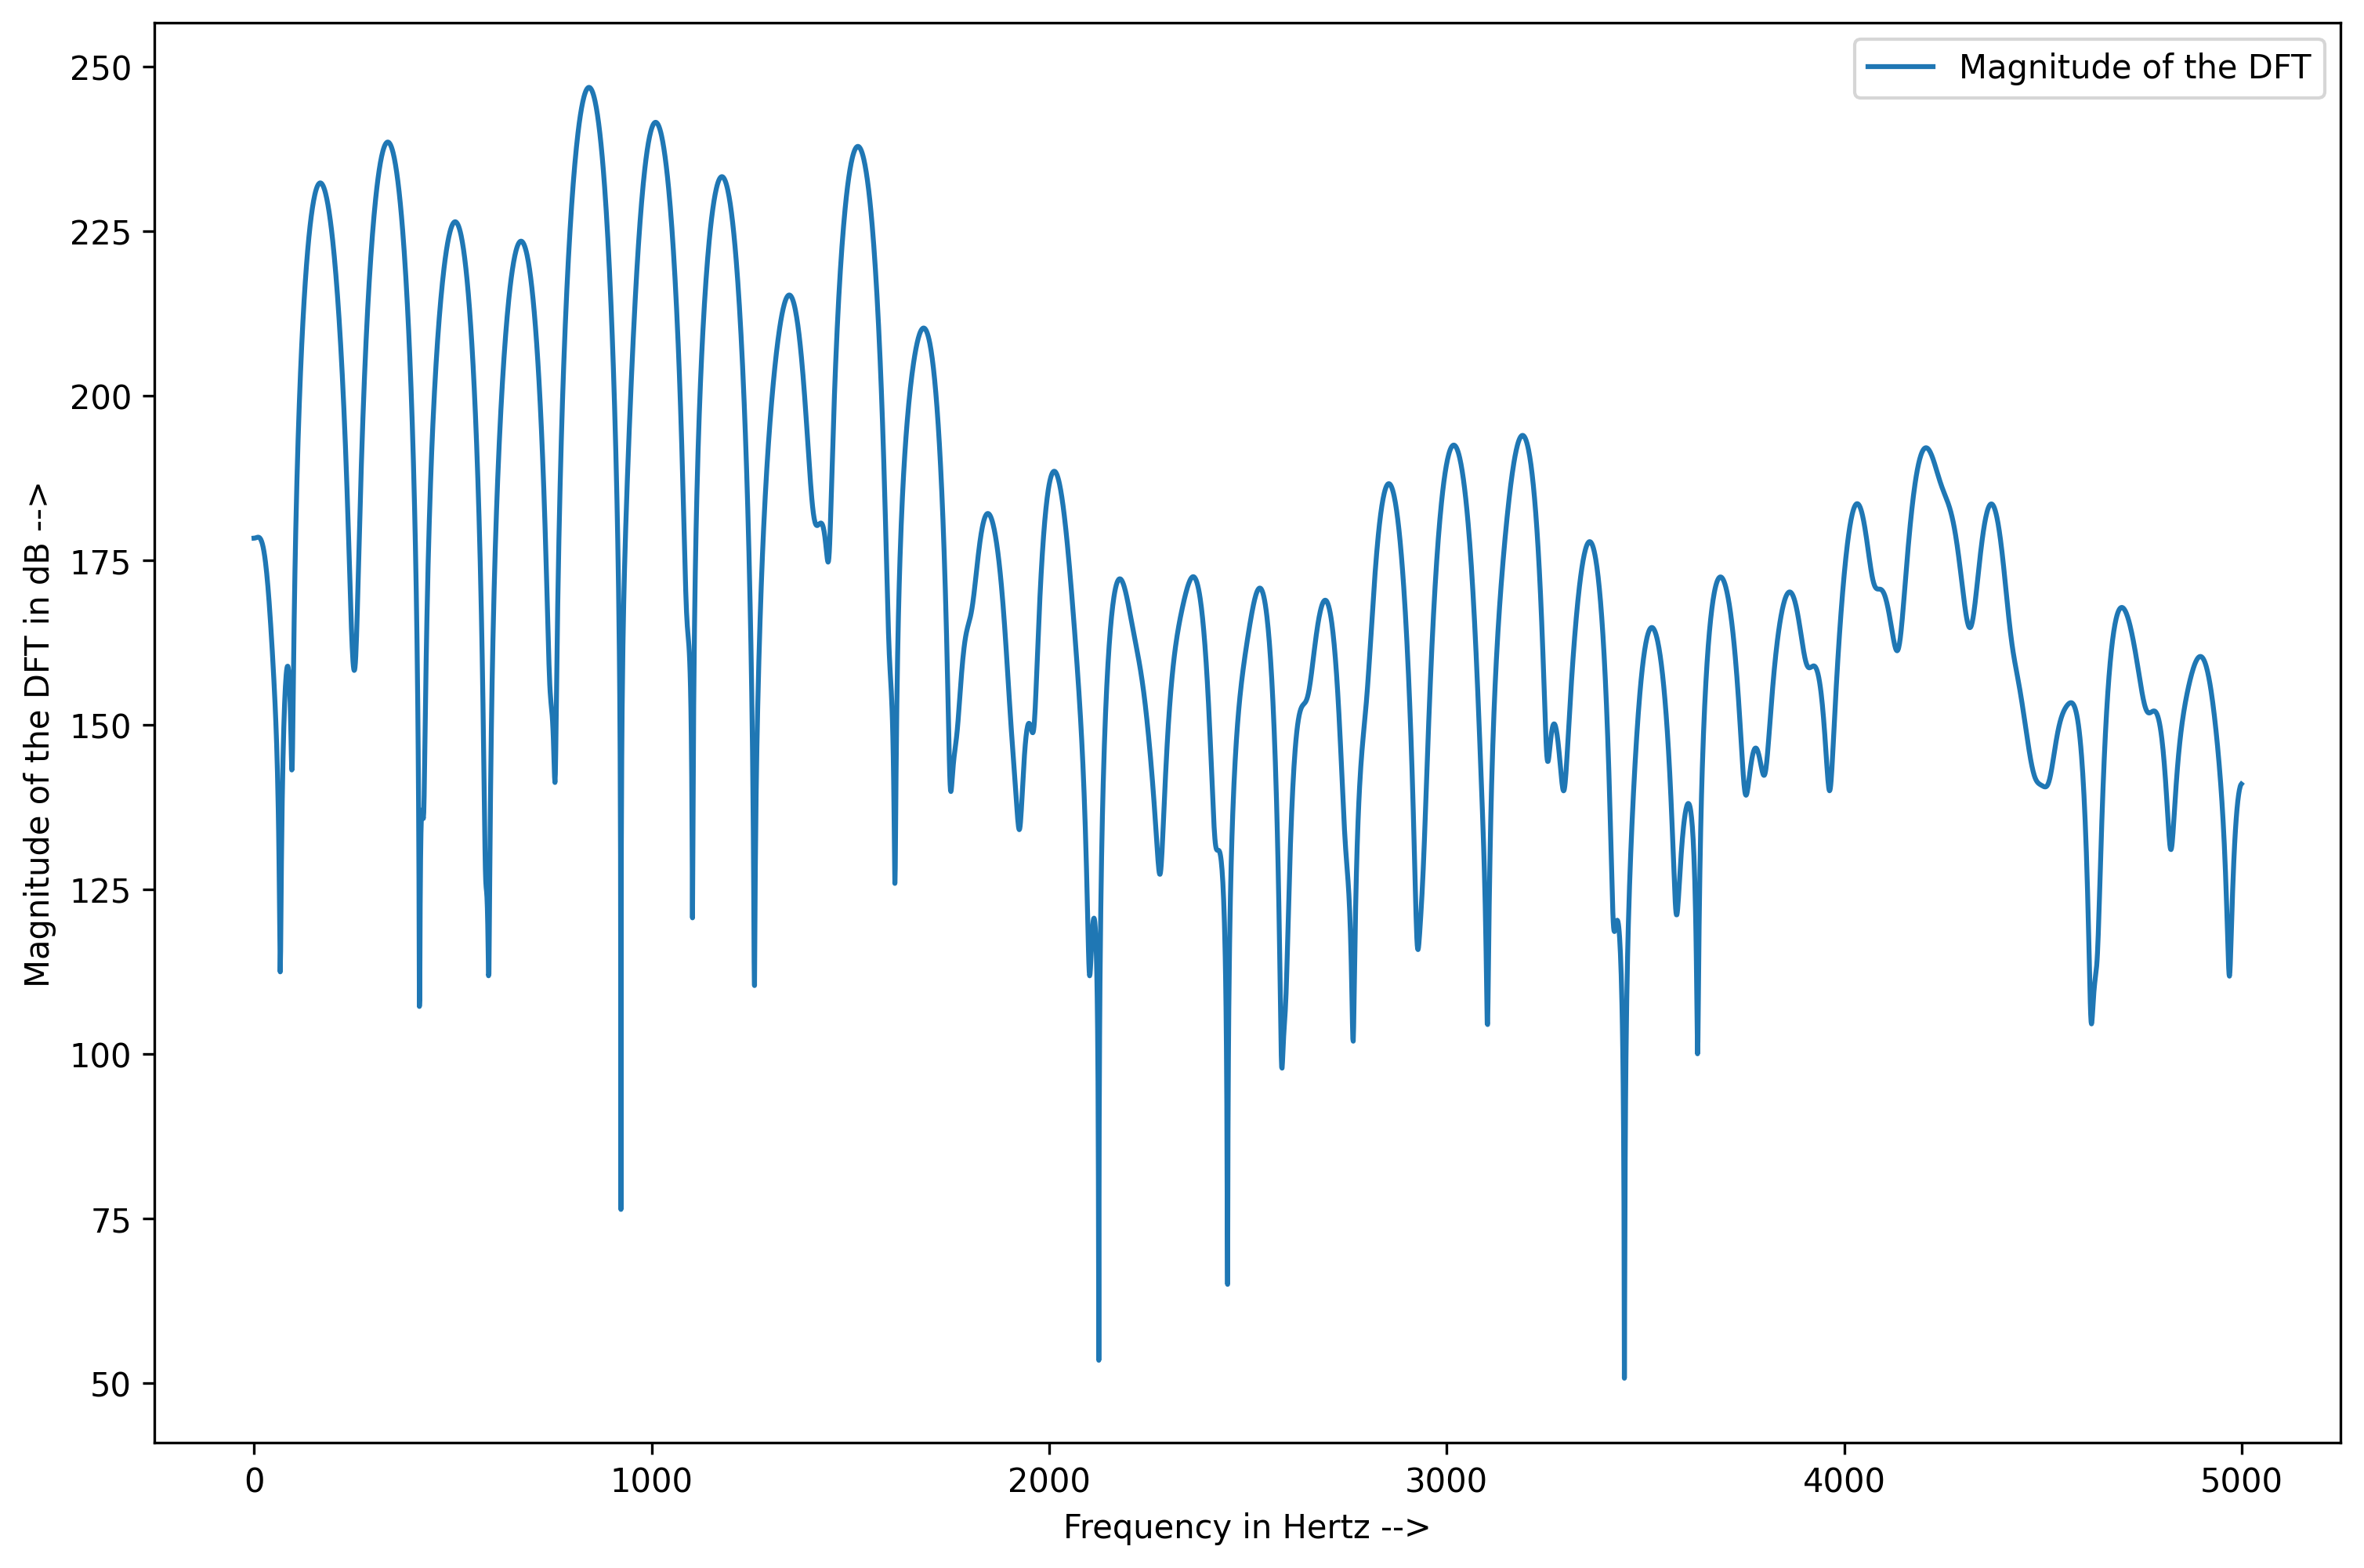

In [30]:
plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
plt.plot(signalHammingDFT)
plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT"])

### Observations [FILLLLLLLLLLLLLLLLLLLLLLLLLLLLl]

# Question 3
With the same 30 ms segment of part 2, compute the autocorrelation coefficients
required for LPC calculation at various p = 2,4,6,8,10. Use the Levinson-Durbin
recursion to compute the LP coefficients from the autocorrelation coefficients. Plot error
signal energy (i.e. square of gain) vs p. 

For a particular p, we only need to compute the autocorrelation functions from 0 to p-1, since only these coefficients show up in our equations.

To compute the ACF : 

$$ r(k) = \frac{1}{2M+1}\sum_{m = -M}^{M} x[m] \times x[m+k]$$

$$ \implies r(k) = \frac{1}{2M+1}\sum_{m = 0}^{2M+1} x[m] \times x[m+k] \text{(when signal is indexed from 0)} $$

Further, since our signal is windowed i.e finite length the autocorrelation is always 0 for all $ k \geq N \text{(the window length)}$

In [187]:
def computeACF(signal, lag):
    #we assume that the signal is windowed
    #padding the signal till twice the length since the signal is finite
    signal = np.array(signal, dtype = float)
    return (1/len(signal))*(np.sum(np.pad(signal, (0, 3*len(signal)), 'constant')*np.pad(signal, (lag, 3*len(signal)-lag), 'constant')))

Text(0, 0.5, 'ACF Value')

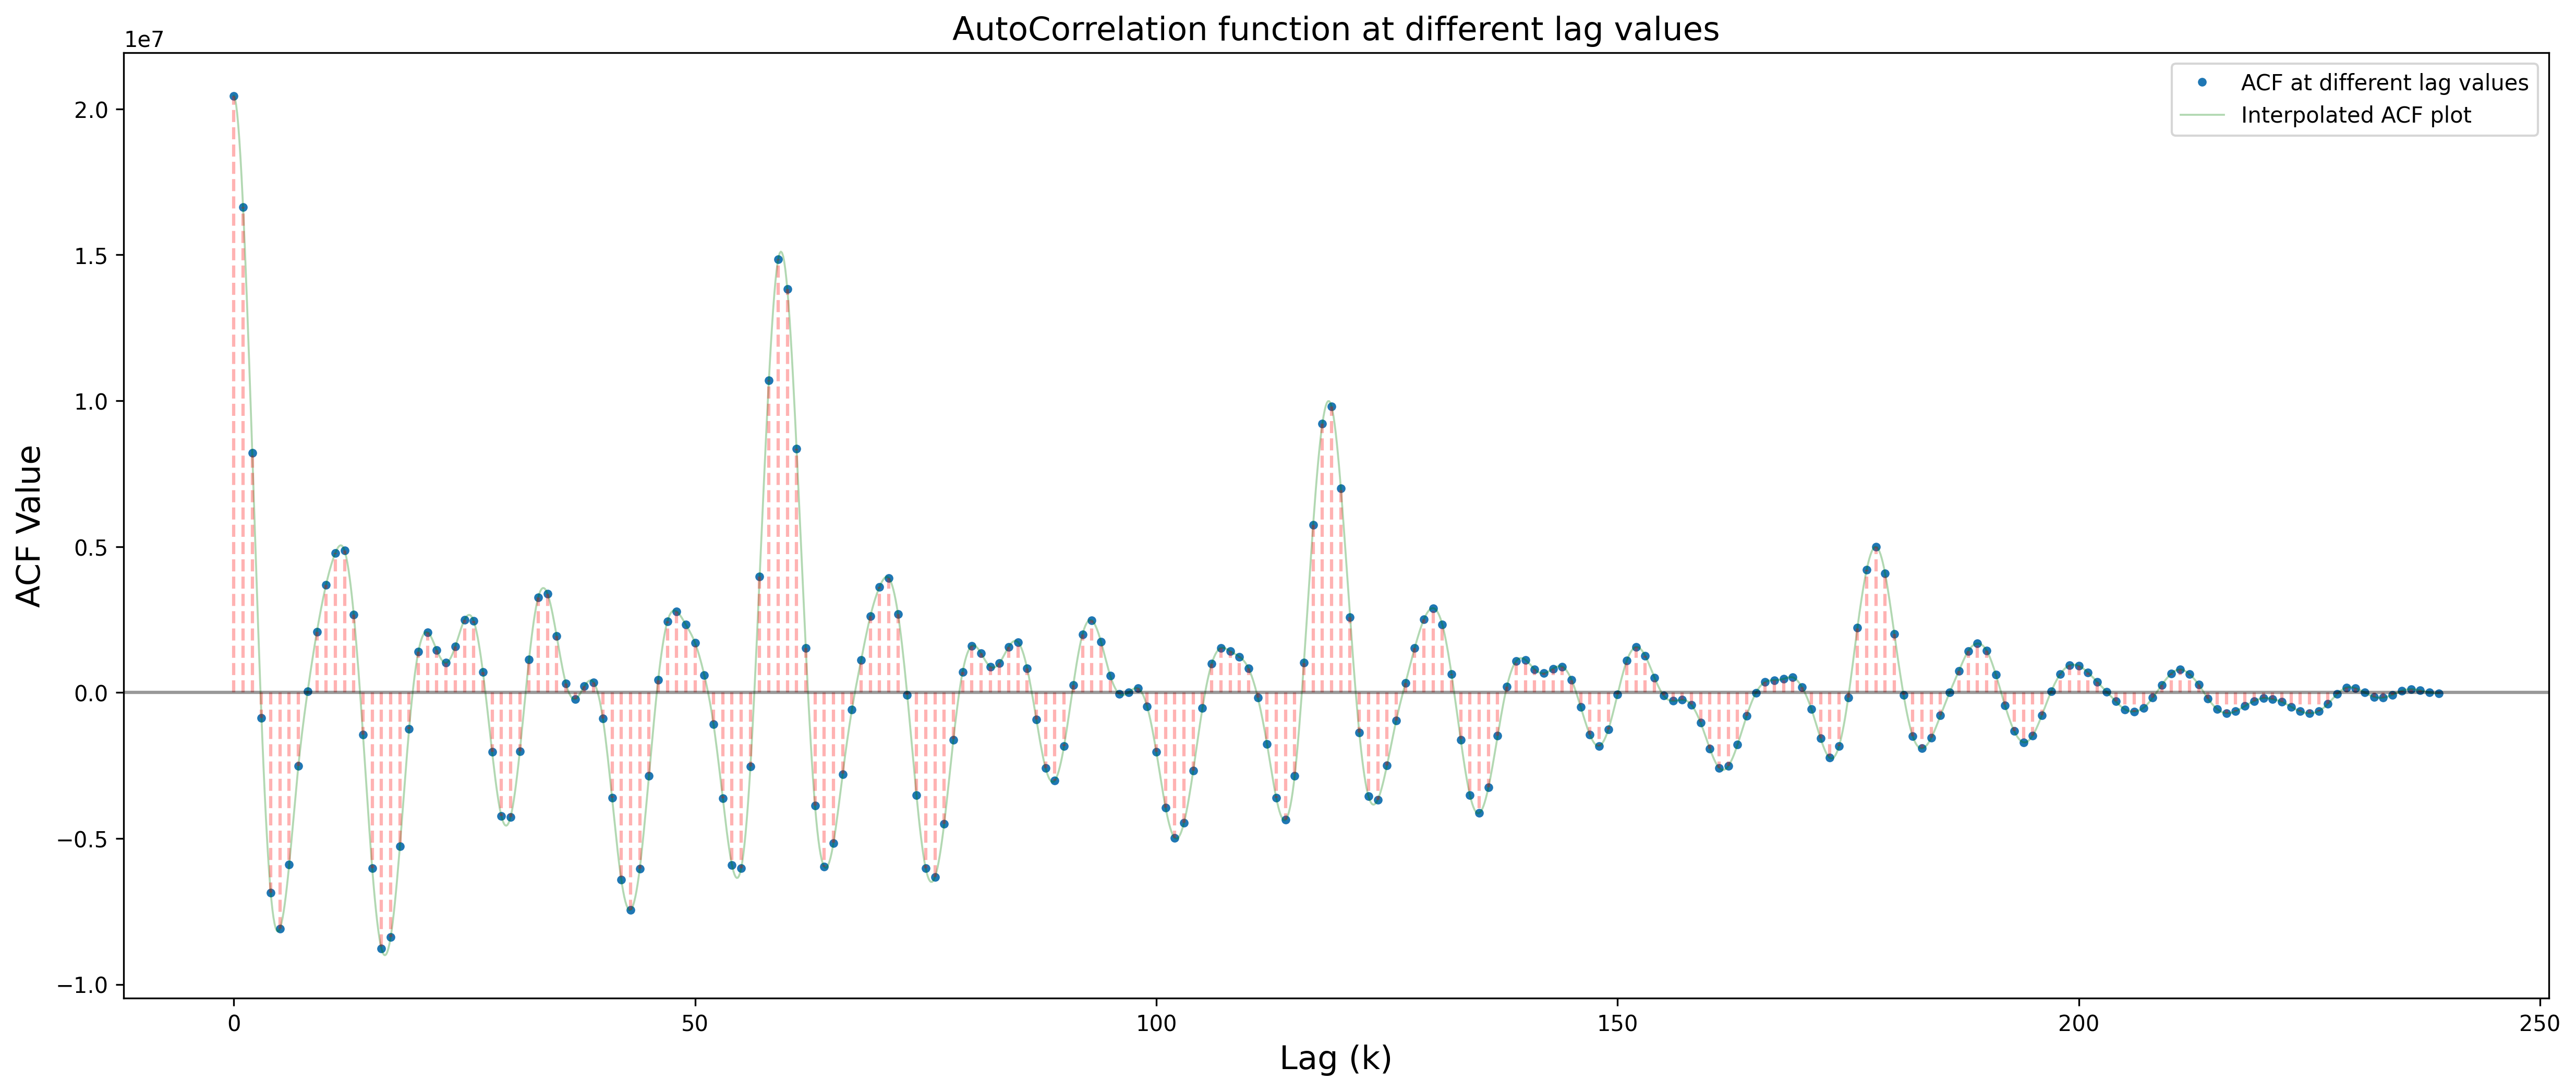

In [368]:
k = [i for i in range(0, 240)]
x = np.linspace(0, 239, 2000)
acf = [computeACF(signalToAnalyse, i) for i in range(0, 240)]
plt.figure(figsize = (20, 8))
plt.gcf().set_dpi(300)
plt.plot(k, acf,'.')
f = interp1d(k, acf, kind='cubic')
plt.plot(x, f(x), alpha = 0.3, linewidth = 0.9, color = 'g')
plt.vlines(k, 0, acf, color='r', linestyles='--', alpha = 0.3)
plt.axhline(0, color = 'k', alpha = 0.4)
plt.legend(["ACF at different lag values", "Interpolated ACF plot"])
plt.title("AutoCorrelation function at different lag values", fontsize= 15)
plt.xlabel("Lag (k)", fontsize= 15)
plt.ylabel("ACF Value", fontsize= 15)

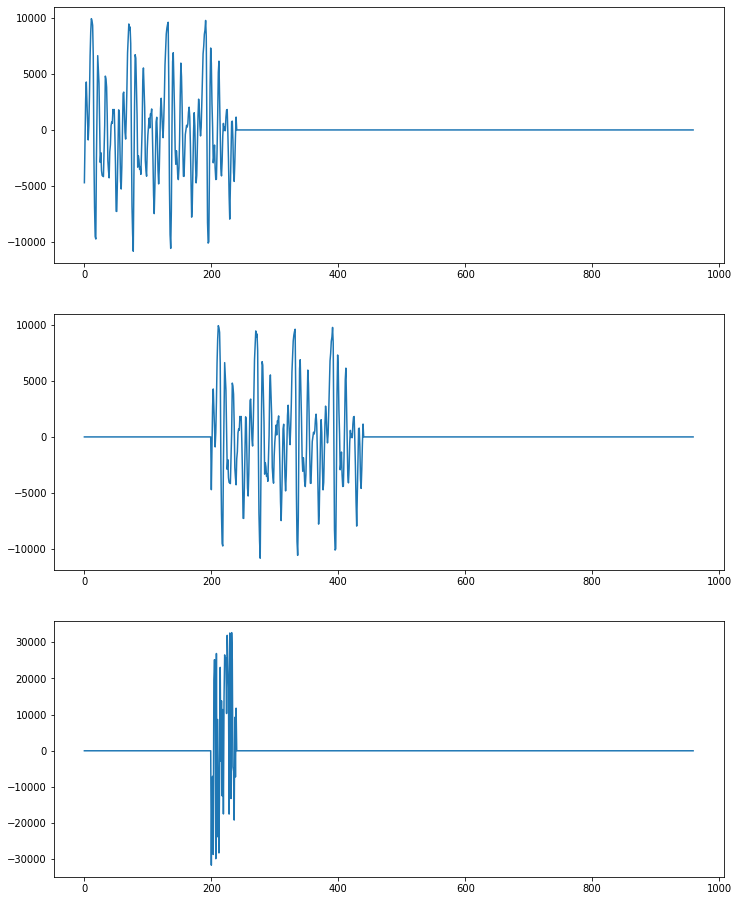

In [104]:
plt.figure(figsize=(12, 16))
plt.subplot(311)
lag = 0
plt.plot(np.pad(signalToAnalyse,(lag, 3*len(signalToAnalyse)-lag), 'constant'))
plt.subplot(312)
lag = 200
plt.plot(np.pad(signalToAnalyse,(lag, 3*len(signalToAnalyse)-lag), 'constant'))
plt.subplot(313)
lag = 200
plt.plot(np.pad(signalToAnalyse,(0, 3*len(signalToAnalyse)), 'constant')*np.pad(signalToAnalyse,(lag, 3*len(signalToAnalyse)-lag), 'constant'))

## The Levinson Durban Recursion

In [304]:
rp = np.array([computeACF(signalToAnalyse, lag = 1)])
pp = np.array([computeACF(signalToAnalyse, lag = 1)])
alpha = np.array([rp[0]/computeACF(signalToAnalyse, 0)])
beta = np.array([rp[0]/computeACF(signalToAnalyse, 0)])
coef = [alpha]


for p in range(1, 10):
    k = (computeACF(signalToAnalyse, p+1) - np.sum(pp*alpha))/(computeACF(signalToAnalyse, 0) - np.sum(rp*alpha))
    alpha = np.append(alpha, 0) - (k*np.append(beta, -1))
    beta = alpha[::-1]
    rp = np.append(rp, computeACF(signalToAnalyse, lag = p+1))
    pp = rp[::-1]
    coef.append(alpha)

In [265]:
coef

[array([0.81339069]),
 array([ 1.4386976 , -0.76876576]),
 array([ 1.46628495, -0.82039379,  0.03588525]),
 array([ 1.4592404 , -0.65934416, -0.25195779,  0.19630771]),
 array([ 1.4480153 , -0.64493692, -0.21425574,  0.11286668,  0.05718114]),
 array([ 1.46235694, -0.61662876, -0.26799337, -0.0488904 ,  0.42035887,
        -0.25081069]),
 array([ 1.45944786, -0.61175314, -0.26856044, -0.05199878,  0.41320677,
        -0.23384924, -0.01159871]),
 array([ 1.45961155, -0.60845291, -0.27439188, -0.05126494,  0.41699686,
        -0.22521579, -0.03219537,  0.01411264]),
 array([ 1.45319847, -0.59382264, -0.17204903, -0.24075719,  0.44029274,
        -0.10052628,  0.24429858, -0.64916591,  0.45442128]),
 array([ 1.51948025, -0.68850984, -0.13641569, -0.25541993,  0.50451375,
        -0.13564307,  0.21920354, -0.73578075,  0.66638449, -0.14585978])]

In [322]:
#checking whether the coefficient are correct
#should preserve the acf!
for p in range(1, len(coef)+1):
    computeACF(signalToAnalyse, 1) == coef[0][0]*computeACF(signalToAnalyse, 0)
    Rind = np.array([[ np.abs(i-k) for k in range(1, p+1)] for i in range(1, p+1)])
    R = np.array([[computeACF(signalToAnalyse, np.abs(i-k)) for k in range(1, p+1)] for i in range(1, p+1)])
    acfArr = np.array([computeACF(signalToAnalyse, i) for i in range(1, p+1)])
    coefArr = coef[p-1]
    if np.sum(np.round(np.matmul(R, coefArr) - acfArr, 7)**2)==0:
        print(f"Order {p} coefficients verified and correct...proceed")
    else:
        print("Error <Coefficients don't match>")
        break

Order 1 coefficients verified and correct...proceed
Order 2 coefficients verified and correct...proceed
Order 3 coefficients verified and correct...proceed
Order 4 coefficients verified and correct...proceed
Order 5 coefficients verified and correct...proceed
Order 6 coefficients verified and correct...proceed
Order 7 coefficients verified and correct...proceed
Order 8 coefficients verified and correct...proceed
Order 9 coefficients verified and correct...proceed
Order 10 coefficients verified and correct...proceed


In [332]:
#computing the minima energy directly from formula
Emin = []
for p in range(1,len(coef)+1):
    acfArr = np.array([computeACF(signalToAnalyse, i) for i in range(1, p+1)])
    E = computeACF(signalToAnalyse, 0) - np.sum(acfArr*coef[p-1])
    Emin.append(E)

In [377]:
error = []
for p in range(1,len(coef)+1):
    signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
    signalEstimate = np.zeros_like(signalToEstimate)
    for i in range(0, len(signalToAnalyse) + p-1):
        signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])
    error.append(np.sum(np.array(signalEstimate - np.pad(np.array(signalToAnalyse, dtype = float),(0, 3*len(signalToAnalyse))), dtype = float)**2))

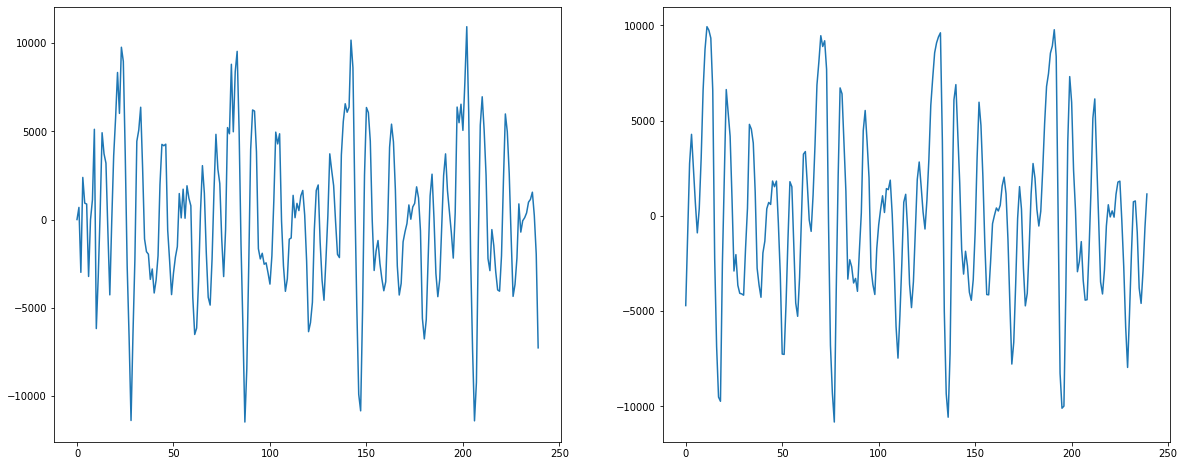

In [378]:
plt.figure(figsize = (20, 8))
plt.subplot(121)
plt.plot(signalEstimate[0:240]) 
plt.subplot(122)
plt.plot(signalToAnalyse)

## Error plots !!!!!![CHECK this shit]

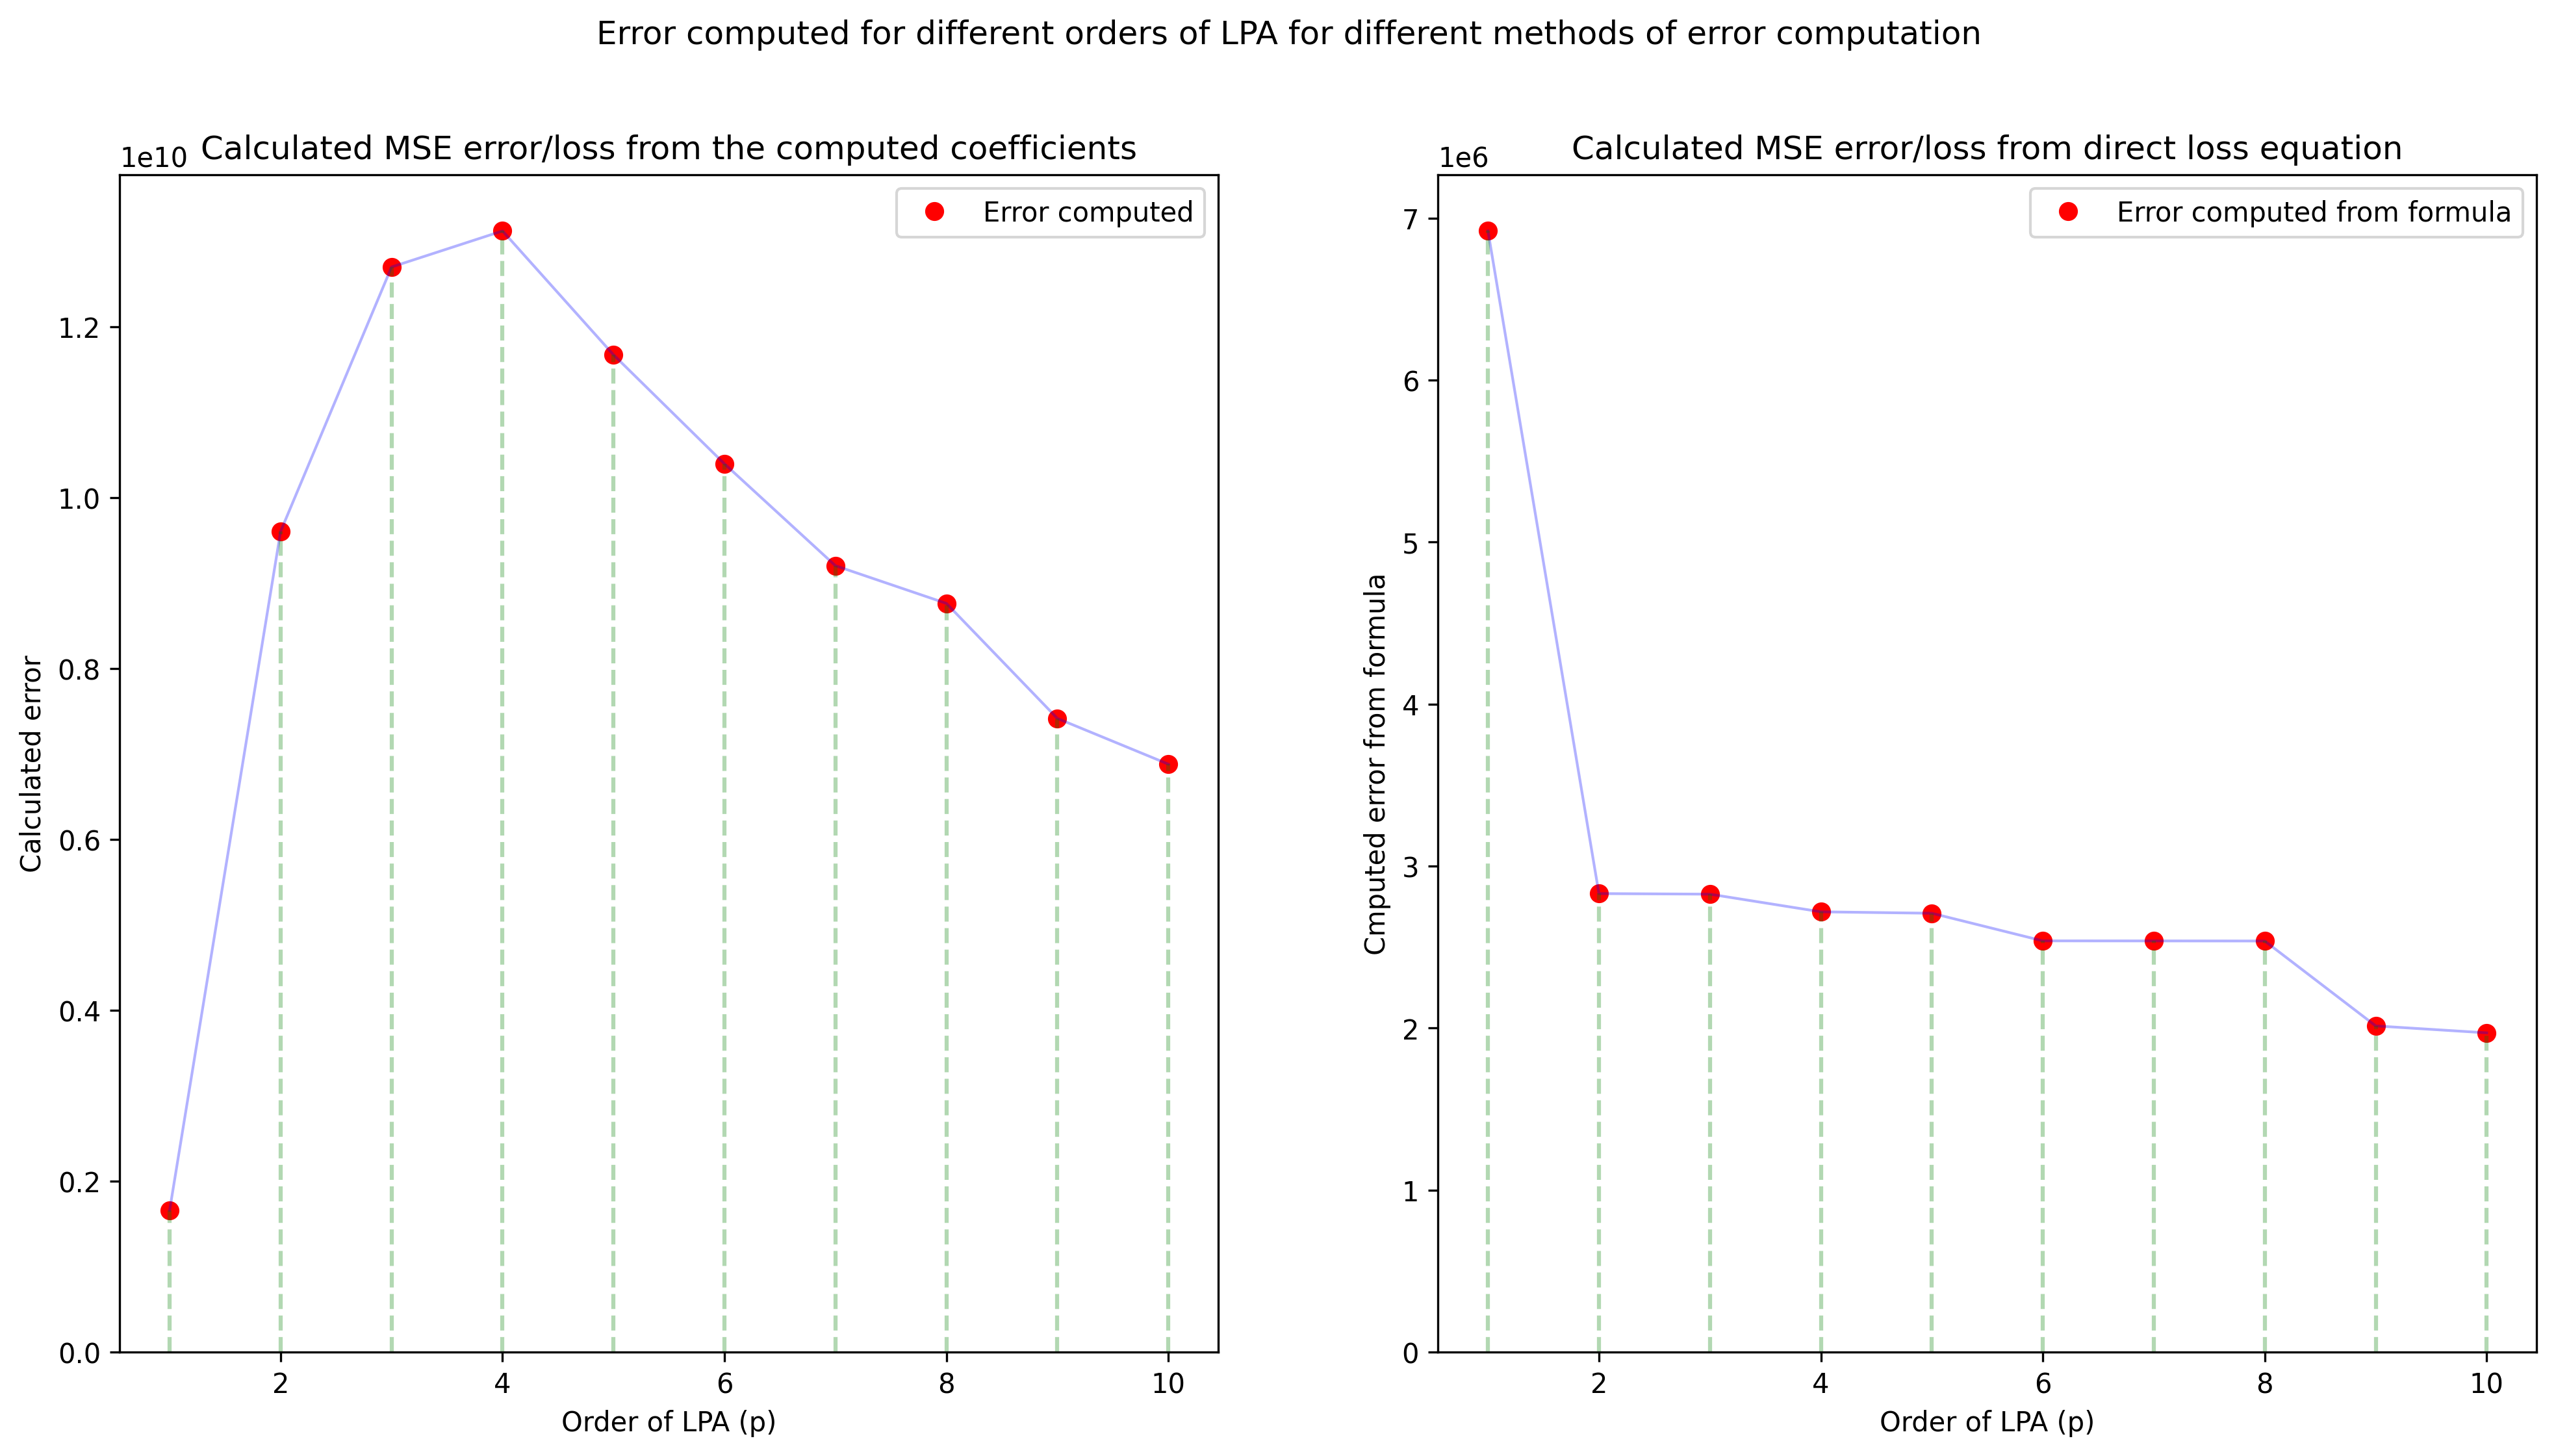

In [342]:
plt.figure(figsize=(16, 8))
plt.gcf().set_dpi(300)
plt.suptitle("Error computed for different orders of LPA for different methods of error computation")
plt.subplot(121)
plt.plot([i for i in range(1, 11)], error, 'ro')
plt.plot([i for i in range(1, 11)], error, 'b', alpha = 0.3, linewidth = 1)
plt.vlines([i for i in range(1, 11)] , 0, error, color='g', linestyles='--', alpha = 0.3)
plt.ylim(bottom=0)
plt.title("Calculated MSE error/loss from the computed coefficients")
plt.xlabel("Order of LPA (p)")
plt.ylabel("Calculated error")
plt.legend(["Error computed"])
plt.subplot(122)
plt.plot([i for i in range(1, 11)], Emin, 'ro')
plt.plot([i for i in range(1, 11)], Emin, 'b', alpha = 0.3, linewidth = 1)
plt.vlines([i for i in range(1, 11)] , 0, Emin, color='g', linestyles='--', alpha = 0.3)
plt.ylim(bottom=0)
plt.title("Calculated MSE error/loss from direct loss equation")
plt.xlabel("Order of LPA (p)")
plt.ylabel("Cmputed error from formula")
plt.legend(["Error computed from formula"])

## Inference
1. We see that the computed loss and the calculated loss both reduce as p increases and finally settle at minima around p=10


# Question 4
Show the pole-zero plots of the estimated all-pole filter for p=6,10; comment. 

## Order of lpa p=6

In [369]:
z, p, k =tf2zpk(1, [1] + coef[5])

In [371]:
#Zeros
z

array([], dtype=float64)

In [372]:
#poles
p

array([ 0.60841262+0.76149379j,  0.60841262-0.76149379j,
       -0.39997079+0.63194174j, -0.39997079-0.63194174j,
       -0.57257644+0.j        ])

(-1.1, 1.1)

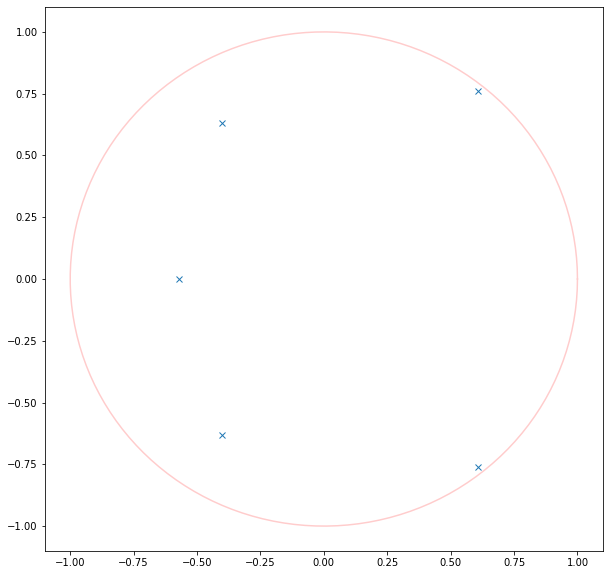

In [370]:
angle = np.linspace( 0 , 2 * np.pi , 150 ) 

radius = 1

x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
plt.figure(figsize=(10,10)) 
plt.plot(x, y, 'r', alpha = 0.2)
plt.plot([i.real for i in p], [j.imag for j in p], 'x')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

## Order of lpa p=10

In [373]:
z, p, k =tf2zpk(1, [1] + coef[-1])

In [374]:
#Zeros
z

array([], dtype=float64)

In [375]:
#poles
p

array([ 0.83636977+0.5419431j ,  0.83636977-0.5419431j ,
        0.42933203+0.85590353j,  0.42933203-0.85590353j,
       -0.2819976 +0.89943685j, -0.2819976 -0.89943685j,
       -0.80786006+0.47835809j, -0.80786006-0.47835809j,
       -0.475321  +0.j        ])

(-1.1, 1.1)

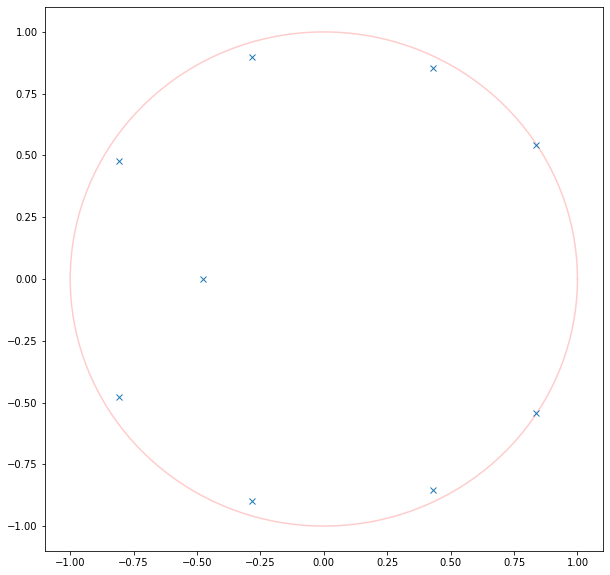

In [376]:
angle = np.linspace( 0 , 2 * np.pi , 150 ) 

radius = 1

x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
plt.figure(figsize=(10,10)) 
plt.plot(x, y, 'r', alpha = 0.2)
plt.plot([i.real for i in p], [j.imag for j in p], 'x')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

## Comments:
1. We see that most poles lie very close to the unit circle
2. We see a pole lying on the real axis in both cases (two poles have the same value i.e the real pole)
3. The real pole has actually 2 poles at the same place hence we see the correct number of poles in each case

# Question 5
1. Compute the gain   
 and 
2. plot the LPC spectrum magnitude (i.e. the dB magnitude
frequency response of the estimated all-pole filter) for each order "p". 
3. Comment on the characteristics of the spectral envelope estimates. 
4. Comment on their shapes with
reference to the short-time magnitude spectrum computed in part 2. 

## Gain ??????//

## LPC spectra magnitude plots

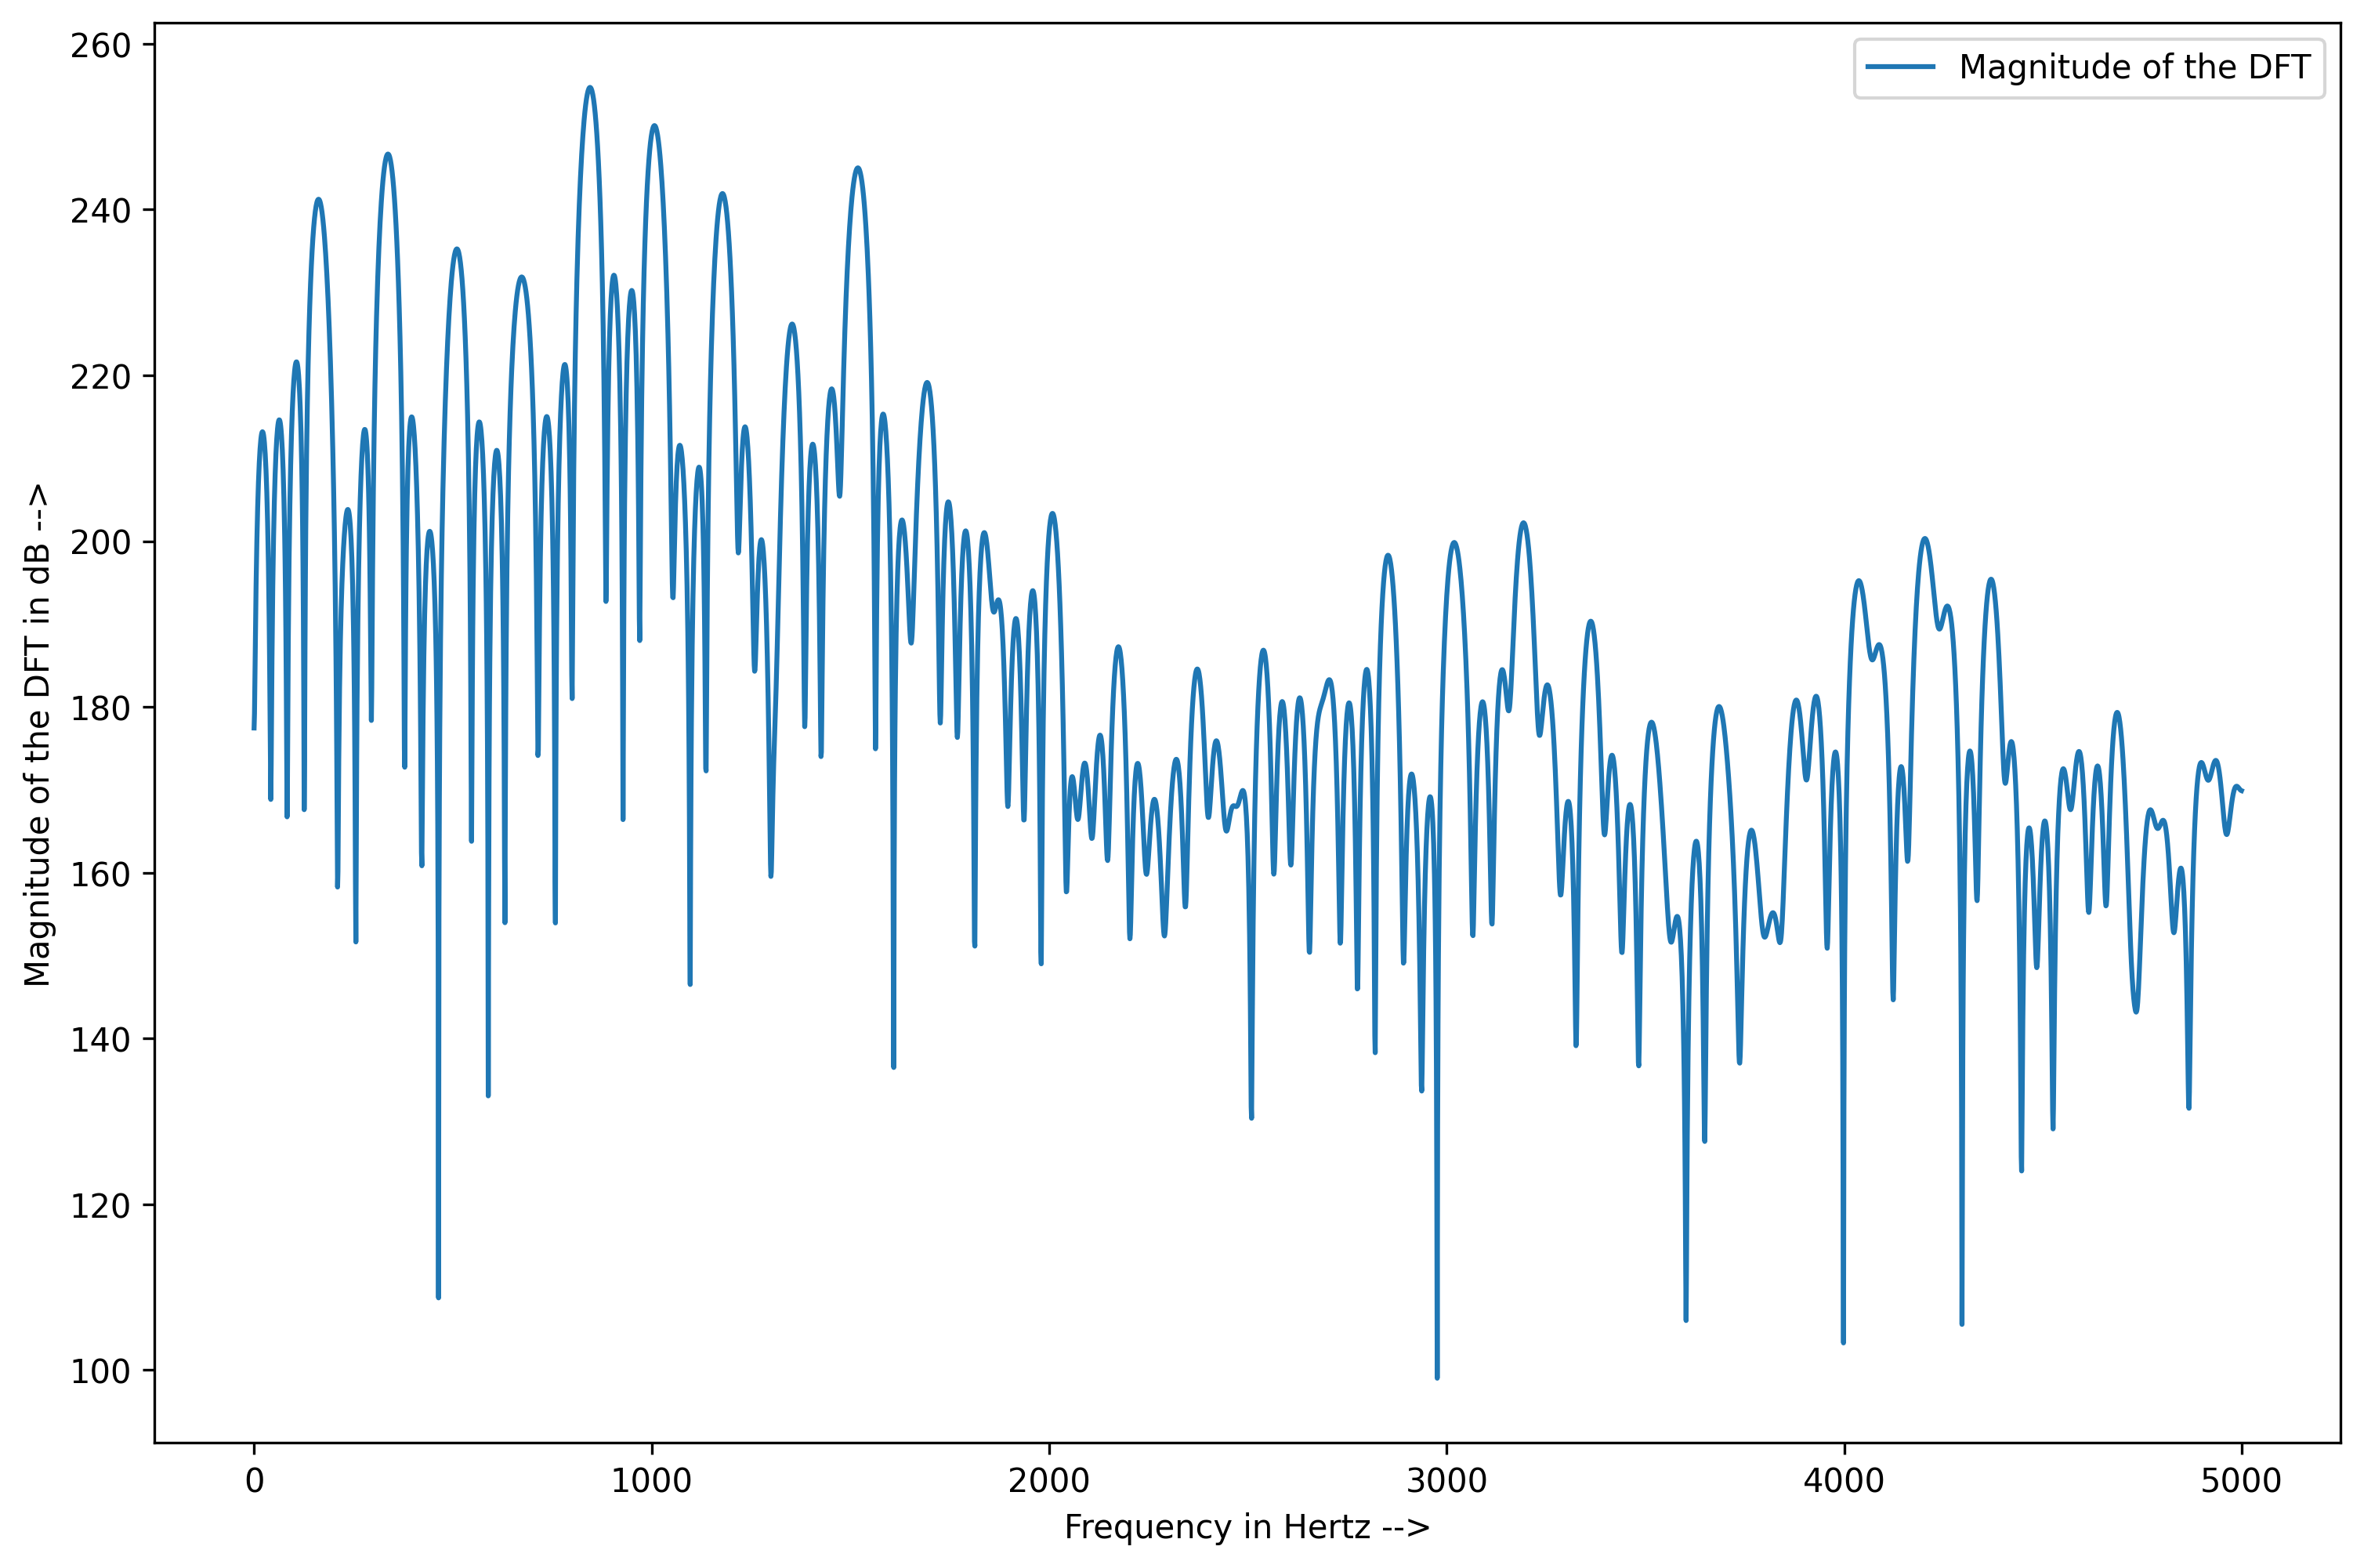

In [415]:
p = 1
signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
signalEstimate = np.zeros_like(signalToEstimate)
for i in range(0, len(signalToAnalyse) + p-1):
    signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])


plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
#plt.subplot(121)
plt.plot(20*np.log(np.abs(np.fft.fft(signalEstimate, dftSize))[:dftSize//2]))

plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT"])
# plt.subplot(122)
# f = interp1d(find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0], 20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2])[find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0]], kind='cubic')
# xNew = np.array([i for i in range(21, 4000)])
# plt.plot(xNew, f(xNew), alpha = 0.3, linewidth = 0.9, color = 'g')
# plt.xlabel("Frequency in Hertz -->")
# plt.ylabel("Magnitude of the DFT in dB -->")
# plt.legend(["Interpolated Magnitude of the DFT"])

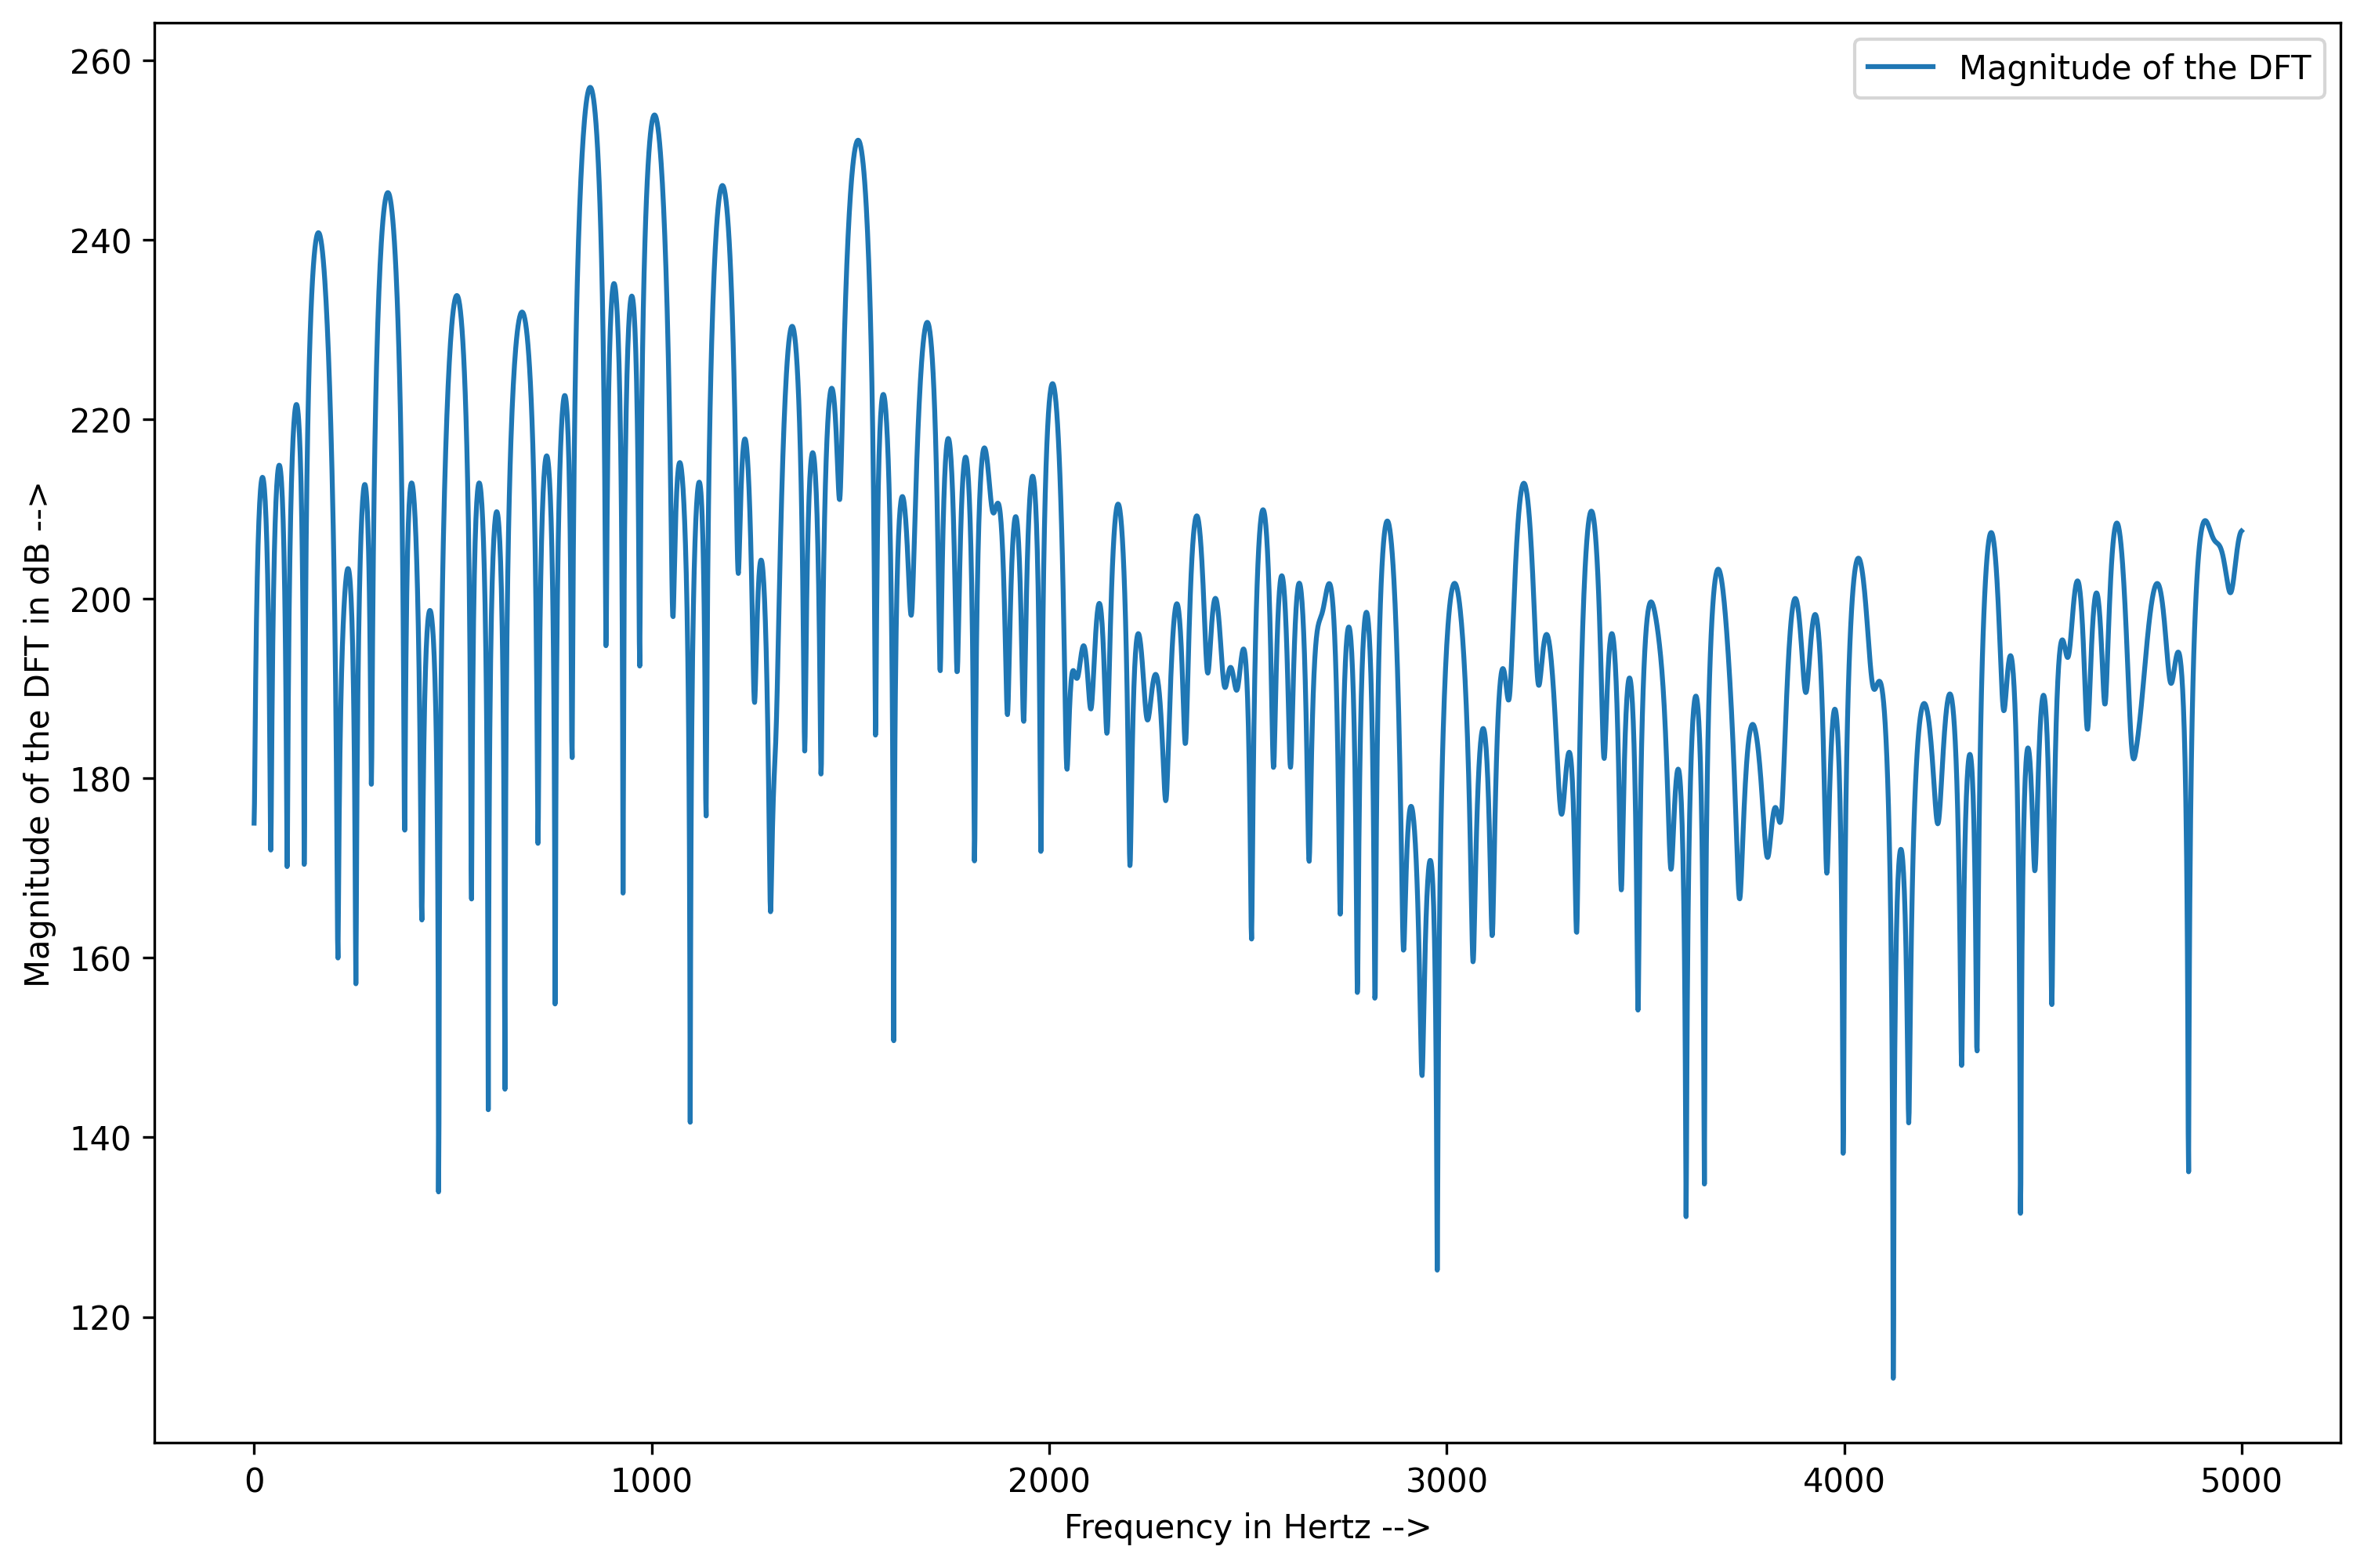

In [418]:
p = 10
signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
signalEstimate = np.zeros_like(signalToEstimate)
for i in range(0, len(signalToAnalyse) + p-1):
    signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])


plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
#plt.subplot(121)
plt.plot(20*np.log(np.abs(np.fft.fft(signalEstimate, dftSize))[:dftSize//2]))

plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT"])